# Web Crawling Mini Project
## 네이버 중고나라에 게시되어 있는 중고 스노우보드 게시글 제목 크롤링
- 네이버에 로그인 한 후 네이버 중고나라에 접속한다.
- 개인정보 보호를 위해 로그인은 1회만 실시, 해당 코드의 셀은 더 이상 실행하지 않고 아이디와 비밀번호는 지운다.(Github 공유)
- 해당 게시글의 제목, 작성자, 게시한 시간, 조회수 크롤링
- 스노우보드는 데크, 바인딩, 부츠로 나눠져 있는데, 데크를 판매중인 게시글만 크롤링한다.

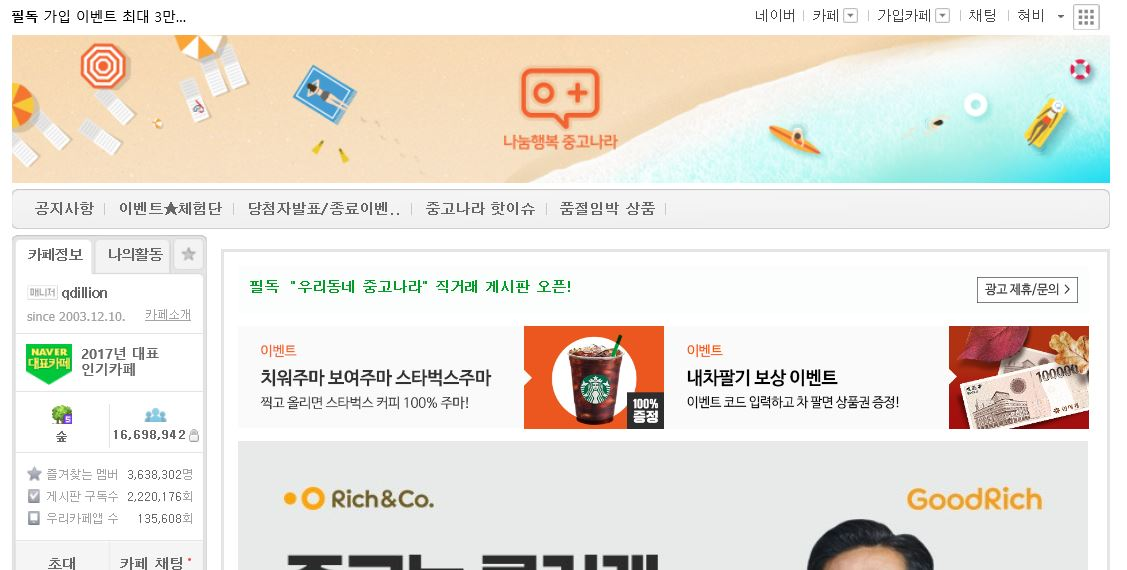

In [1]:
from IPython.display import Image
Image('joonggonara.jpg')

### 0. 네이버 중고나라 페이지 탐색
- 중고 스노우보드 관련 게시글은 스포츠/레저의 하위 카테고리 스키/보드/의류에 게시된다.
- 카테고리, 페이지 번호가 넘어갈 때 URL이 바뀌지 않는다.(Selenium 이용)
- 스노우보드 뿐만 아니라 스키, 의류들도 같이 게시되어 있으므로 검색창을 활용한다.(검색어 : 스노우보드, 보드, 스노보드)

### 1. 네이버 로그인

In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
import time

driver = webdriver.Chrome('Chromedriver')
driver.get('https://naver.com') # 네이버 접속
driver.find_element_by_class_name('ico_local_login').click() # 로그인 페이지에 접속(tag : i)

ID = '-----'
PW = '-----------'
id_input = driver.find_element_by_name('id') 
pw_input = driver.find_element_by_name('pw')

# 자동입력문자방지로 인핸 로그인 실패 방지
for word in ID:
    id_input.send_keys(word)
    time.sleep(0.3)

for word in PW:
    pw_input.send_keys(word)
    time.sleep(0.3)

driver.find_element_by_class_name('btn_global').click() #tag : input

### 2. 중고나라 접속

In [2]:
# 검색창에 중고나라 검색
driver.find_element_by_name('query').send_keys('중고나라') # 검색창에 '중고나라' 입력
driver.find_element_by_id('search_btn').click() # 검색 클릭
driver.implicitly_wait(5) # 페이지 로딩시간 대기

# 중고나라 접속
driver.find_element_by_id('web_layer_0') # '중고나라'링크가 포함되어 있는 HTML부분 찾기 
driver.find_element_by_class_name('title_link').click() # '중고나라'링크 클릭
driver.switch_to.window(driver.window_handles[1]) # 새로 열린 Tab으로 driver 변경

### 3. 스키/보드/의류 카테고리 접속

In [3]:
# Scroll Method 2
driver.execute_script('window.scrollTo(0, document.body.scrollHeight)')# 바닥까지 내리는 방법
driver.find_element_by_id('menuLink435').click() # 카테고리(스키/보드/의류) 클릭

### 4. 검색창에 '스노우보드' 검색(검색유형 : 제목만)

In [6]:
driver.execute_script('window.scrollTo(0, document.body.scrollHeight)')# 바닥까지 내리는 방법
driver.find_element_by_class_name('Flash_det_close').click()
# #document로 들어가기
iframe = driver.find_elements_by_id('cafe_main')[0] # tag : iframe이 여러개임으로 해당하는 iframe의 id를 이용
driver.execute_script("arguments[0].removeAttribute('scrolling')", iframe)
driver.switch_to_frame(iframe) # switch_to_frame() 이용하여 #document 속으로 이동
driver.implicitly_wait(10)

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"class name","selector":"Flash_det_close"}
  (Session info: chrome=69.0.3497.100)
  (Driver info: chromedriver=2.41.578737 (49da6702b16031c40d63e5618de03a32ff6c197e),platform=Windows NT 10.0.17134 x86_64)


In [7]:
from selenium.webdriver.support.ui import Select
driver.find_element_by_name('frmSearch').find_elements_by_css_selector('input.m-tcol-c')[1].click() # Dropdown click하여 option 열기
option = driver.find_elements_by_css_selector('ul.seljs_option li') # dropdown이 열린 상태에서 option들의 실제 value가 있는 tag 찾기
for opt in option:
    print(opt.text)

driver.find_element_by_css_selector('ul.seljs_option').find_element_by_xpath('./li[.="제목만"]').click() # 원하는 value 클릭

# 검색창에 '데크' 검색하기
driver.find_element_by_id('query').send_keys('데크')
driver.find_element_by_class_name('btn-search-green').click()

IndexError: list index out of range

### 5. 게시글 제목, 작성자, 업로드 시간, 조회수 크롤링
- 크롤링 시 조건을 걸어 내가 필요한 물품(데크)만 판매하는 게시글 수집, 따라서 검색어를 '스노우보드'가 아닌 '데크'로 검색
- 페이지를 넘겨가면서 크롤링, 10페이지만 시도

In [15]:
# 게시글 crawling
titles, uploaders, times_and_clickers = [], [], []
for i in range(10):
    driver.find_element_by_link_text('{}'.format(i+1)).click() # 페이지번호 클릭
    driver.execute_script('window.scrollTo(0, document.body.scrollHeight)') # 페이지로딩
    html = driver.page_source # 현재 html 크롤링
    soup = BeautifulSoup(html, 'html.parser') # Html을 python으로 읽을 수 있도록 파싱(변환)
    titles += soup.select('span.aaa a.m-tcol-c') # 게시글 제목 부분 모으기
    uploaders += soup.select('span.wordbreak') # 게시글 작성자 부분 모으기
    times_and_clickers += soup.select('td.view-count') # 업로드 시간과 조회수 부분 모으기

# Text부분만 추출하기    
title_list, uploader_list, time_and_clicker_list, time_list, clicker_list = [], [], [] ,[], []
# 게시글 제목, 작성자 추출
for title, uploader in zip(titles, uploaders):
    title_list.append(title.text.strip())
    uploader_list.append(uploader.text.strip())

# 업로드 시간, 조회수 추출
for time_and_clicker in times_and_clickers:
    time_and_clicker_list.append(time_and_clicker.text.strip())
time_list = time_and_clicker_list[0::2]
clicker_list = time_and_clicker_list[1::2]

# Dataframe형태로 생성 및 저장
import pandas as pd
data = {'title' : title_list, 'uploader' : uploader_list, 'time' : time_list, 'clicker' : clicker_list}
df = pd.DataFrame(data, columns = ['title', 'uploader', 'time', 'clicker'])
df.to_csv('중고나라_데크.csv')
df

,title,uploader,time,clicker
0,살로몬 아이돌 15/16 데크 144 + 나이트로 바인딩 +써리투 라쉬드 230,우앙우앙1234,19:07,17
1,다이나스타 데크 146 드레이크 바인딩 sm(235~265) 팝니다,우짜짜화니,19:07,4
2,1718 GNU 여자데크 레이디스초이스 142 + 1718 벤트메탈 바인딩,이수,18:26,21
3,살로몬 데크 바인딩 부츠. 데몬 헬멧 고글 풀 셋트 판매합니다,kjo9836,18:19,62
4,"입문용 해머데크 세트, 기타 보드복",AsFarital,17:57,74
5,17/18 011 플랫킹 데크 150 판매합니다.,wlsgns,17:51,46
6,스노우보드 데크,폴리구조대,16:56,99
7,스노우보드 데크와 바인딩 판매합니다,didwldmsdldl,16:21,82
8,15/16 f2 카본 데크 161 팝니다(엣지백 포함),블루미카,15:31,98
9,"[1718 니데커 에어리어153] 라이딩용데크, [1516 얼라이언 아틀란티스 15...",lmk403,14:45,54


## 발생한 오류들 정리
### 1. 자동문자입력방지로 인해 로그인이 안 될 때
- 입력속도가 빠르면 로봇으로 인식한다고 판단
- ID와 PW 입력란에 한 글자씩 천천히 입력, for구문과 time.sleep(second)를 이용

### 2. '중고나라'를 검색한 후 사이트를 클릭했을 때 새로운 Tab으로 열려서 다음 코드들이 적용되지 않음
- 현재 driver는 처음에 켜진 Tab을 다루고 있어서 새로운 Tab에 대한 권한이 없었다는게 원인.
- driver.window_handles : 현재 켜져있는 tab의 명단 출력(list).
- driver.switch_to.window(driver.window_handles[1])로 해결.

### 3. 누루고자 하는 카테고리(스키/보드/의류)의 element는 찾는데 click은 작동하지 않음
- 여러 시험 끝에 스크롤이 해당 카테고리까지 내려가야 click이 작동된다는 사실을 알아냄.
- 스크롤을 자동으로 내리는 코드를 작성
#### *스크롤 내리는 방법*
    1. 단순히 window height 값을 넣어줘서 내리는 방법
        - driver.execute_script('window.scrollTo(0, 5700)')
    2. 바닥까지 내리는 방법
        - driver.execute_script('window.scrollTo(0, document.body.scrollHeight)')
    3. 내가 원하는 element까지만 내리는 방법
        - driver.find_element_by_id('menuLink435').location_once_scrolled_into_view

    **참고https://stackoverflow.com/questions/20986631/how-can-i-scroll-a-web-page-using-selenium-webdriver-in-python**

### 4. 검색유형을 '제목만'으로 변경하는 과정에서 해당 element를 찾지 못함
- HTML에는 육안으로 보이지만 find_element로는 찾을 수 없음, 원인은 iframe으로 인해 찾지 못했던 것
- switch_to_frame() 함수 이용하여 해결
- Iframe에 대하여https://whatis.techtarget.com/definition/IFrame-Inline-Frame

### 5. 게시글 검색창 왼쪽에 있는 Dropdown 옵션을 바꿀 수 없음
    
- 해당 dropdown에 해당하는 element를 찾아 클릭하는 것 까진 했지만 다른 값으로 바꾸진 못했음.
- 결국 구글링에 실패해서 StackOverFlow에 질문했음https://stackoverflow.com/questions/52262430/how-to-select-a-value-from-options-as-per-the-html-through-selenium-and-python/52262586?noredirect=1#comment91486848_52262586
- 답변자가 알려준 방법은 HTML 안에서 내가 찾던 [select] 부분 안에 [style attribute] > Display:none 부분을 지움으로써 오류 해결
- 위 방법은 단지 보유주기 식 해결방법, 실제로 효과가 적용되지는 않음
- 진짜 해결방법 https://stackoverflow.com/questions/52156388/how-do-i-select-items-from-a-drop-down-box-in-selenium-using-python/52157900#52157900
- Dropdown을 클릭한 후 html를 확인해보니 select말고 다른 곳에서 같은 option을 또 볼 수 있었음(실제 value가 있는 tag)
- 즉 위에서 찾은 select는 단지 시각적으로 보일 뿐, 진짜 option의 value는 다른 tag에 있었음

### 6. 검색창에 단어를 입력한 후 검색 버튼을 누루면 해당 단어가 검색창에서 지워지지 않는다.

- 해당 단어가 없어지지 않아 다른 단어를 입력해도 처음 입력한 단어로 검색이 실행됨
- 아직 원인 불명

### 7. 제목 부분을 크롤링했을 때 가끔 [1](댓글 달린 갯수)가 같이 크롤링 된다.
- 두 개의 class를 모두 만족시키는 tag를 찾아야 함
- select('tag.class > tag.class')를 통해 뒤에 같이 따라오는 tag를 제거했다.
    
### 8. 업로드 시간과 조회수가 같은 tag와 같은 column을 사용해서 분류할 수 없다.
- 짝수index(조회수)와 홀수index(시간)으로 분류
- 여러 tag들 한 번에 찾기https://stackoverflow.com/questions/42177826/retrieving-multiple-tags-via-beautifulsoup-css-selector

### 9. 네이버 배너에 의해 Dropdown 클릭이 되지 않았다.
- 그냥 배너를 삭제해버렸다.(간단하죠?)

## 새로 배운것들
**1. Dropdown에는 두 가지 방법이 존재한다.**
- select와 option으로 이루어진 native한 dropdown : 단순히 select와 option tag로 접근 가능하다.
- css를 이용하여 만드는 dropdown : 보여지는 tag는 따로 있고 value가 포함되어 있는 tag(ul, li 등)이 따로 있을 가능성이 있다.
- 두 가지 종류의 dropdown에 따라 접근하는 방법이 다르다.
    
    
**2. 가끔 페이지마다 스크롤을 통해 로딩해줘야 하는 HTML이 있음.** 